In [47]:
cd /projects/foldtree2

[Errno 2] No such file or directory: '/projects/foldtree2'
/home/dmoi/projects/foldtree2


In [48]:
from Bio.PDB import PDBParser
import numpy as np
from scipy.spatial.distance import cdist

# Load structure (replace 'your_structure.pdb' with your PDB file)
parser = PDBParser(QUIET=True)
structure = parser.get_structure('protein', './config/1eei.pdb')

# Extract alpha carbon coordinates
ca_coords = []
for model in structure:
	for chain in model:
		for residue in chain:
			if 'CA' in residue:
				ca_coords.append(residue['CA'].get_coord())
ca_coords = np.array(ca_coords)

# Compute distance matrix
dist_matrix = cdist(ca_coords, ca_coords)

# FFT of each row
fft_matrix = np.fft.fft(dist_matrix, axis=1)

print("Distance matrix shape:", dist_matrix.shape)
print("FFT matrix shape:", fft_matrix.shape)

Distance matrix shape: (515, 515)
FFT matrix shape: (515, 515)


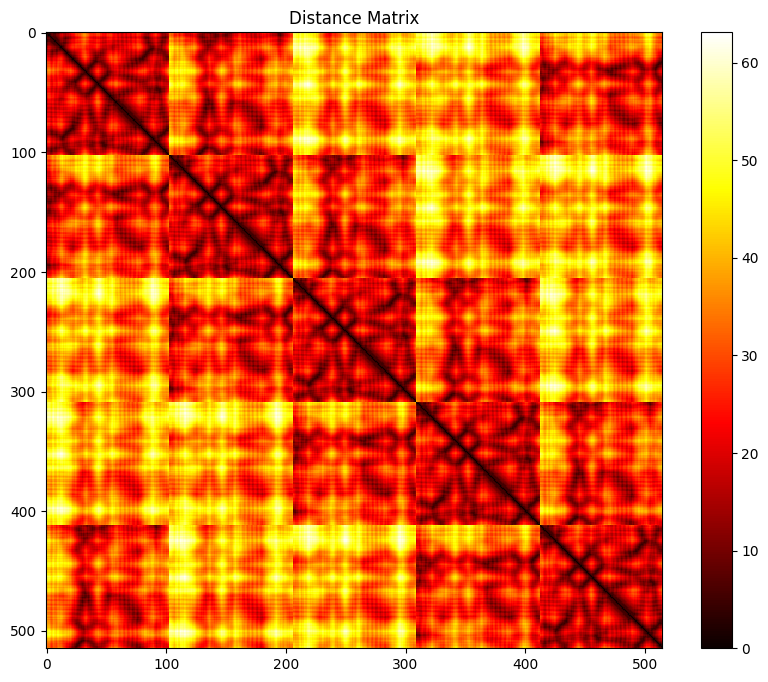

In [49]:
#plot the distance matrix
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.imshow(dist_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Distance Matrix')
plt.show()

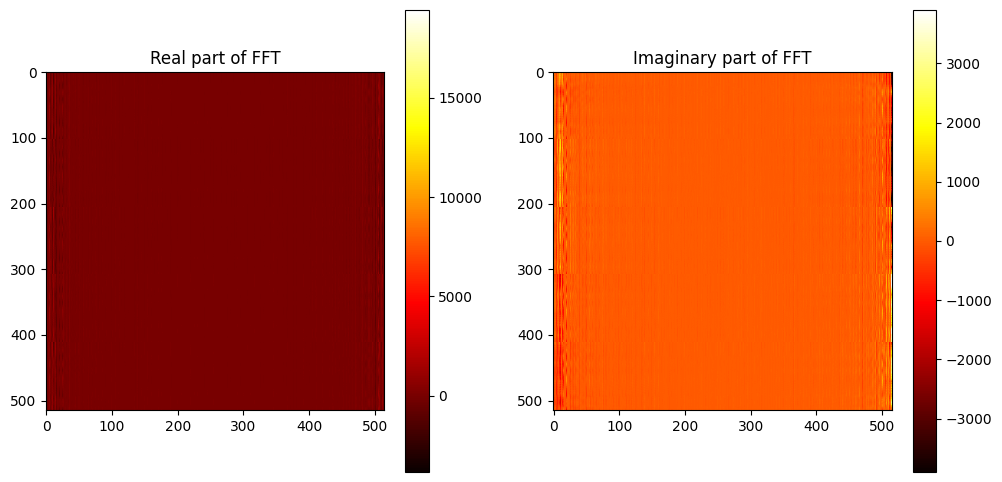

In [50]:
#plot the real and imaginary parts of the FFT
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.real(fft_matrix), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Real part of FFT')
plt.subplot(1, 2, 2)
plt.imshow(np.imag(fft_matrix), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Imaginary part of FFT')
plt.show()

Text(0.5, 0, 'Frequency')

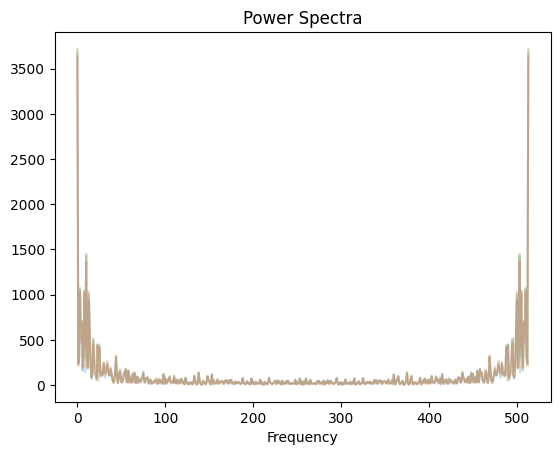

In [51]:
#plot power spectrum
for i in range(4):
	plt.plot(np.abs(fft_matrix[i][1:]), label=f'Row {i}' , alpha = .2)
plt.title('Power Spectra')
plt.xlabel('Frequency')

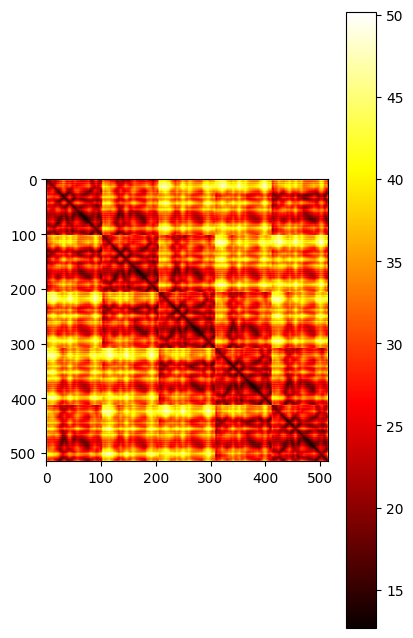

In [52]:
#low pass filter
def low_pass_filter(fft_matrix, cutoff):
	filtered_fft = np.copy(fft_matrix)
	filtered_fft[:, cutoff:] = 0
	return filtered_fft

cutoff_mat = 100
filtered_fft = low_pass_filter(fft_matrix, cutoff_mat)

#reconstruct the filtered distance matrix
reconstructed_matrix = np.fft.ifft(filtered_fft, axis=1)
reconstructed_matrix = np.real(reconstructed_matrix)
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(reconstructed_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()


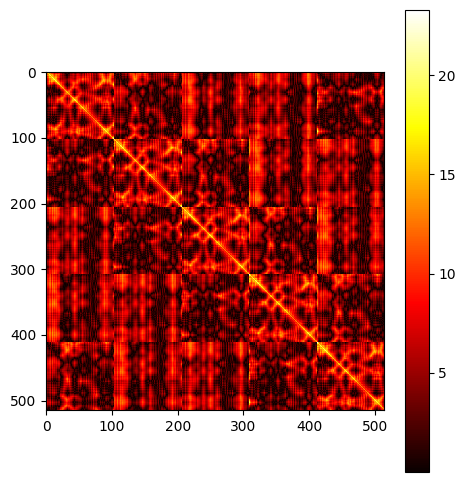

In [53]:
# plot the difference between the original and reconstructed distance matrix
#change figure size
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.imshow(np.abs(dist_matrix - reconstructed_matrix), cmap='hot', interpolation='nearest')
plt.colorbar()

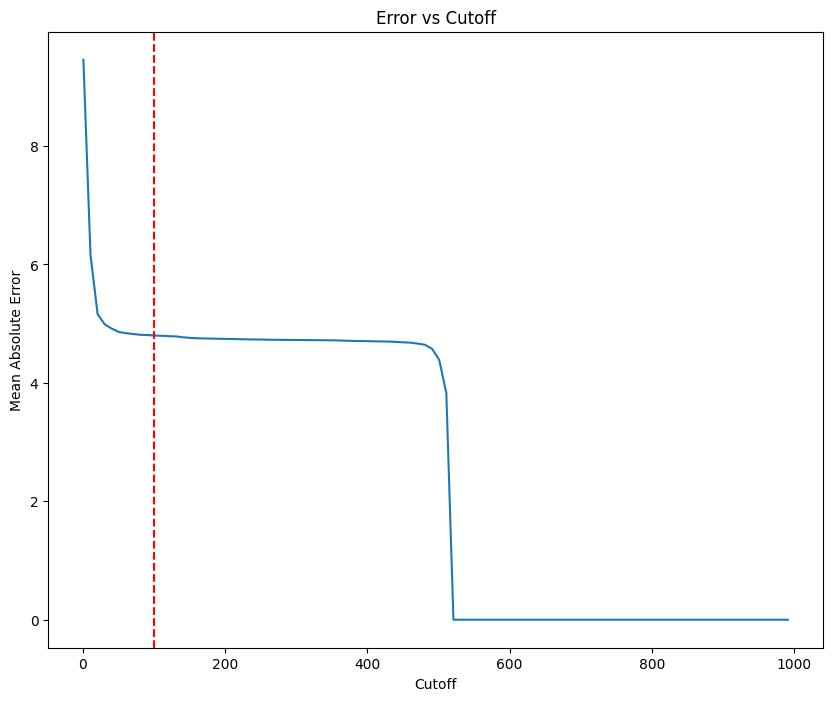

In [54]:
#plot error as a function of cutoff
cutoffs = np.arange(1, 1000, 10)
errors = []

for cutoff in cutoffs:
	filtered_fft = low_pass_filter(fft_matrix, cutoff)
	reconstructed_matrix = np.fft.ifft(filtered_fft, axis=1)
	reconstructed_matrix = np.real(reconstructed_matrix)
	error = np.mean(np.abs(dist_matrix - reconstructed_matrix))
	errors.append(error)
plt.figure(figsize=(10, 8))
plt.plot(cutoffs, errors)
plt.title('Error vs Cutoff')
plt.xlabel('Cutoff')
plt.ylabel('Mean Absolute Error')
#place a vertical line at 100 
plt.axvline(x=cutoff_mat, color='r', linestyle='--', label='Cutoff = 100')
plt.show()

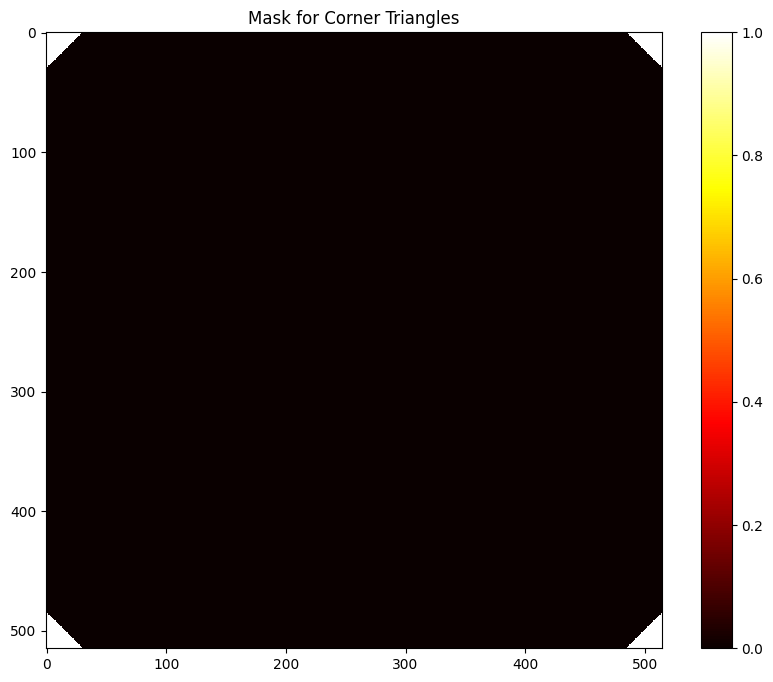

Number of elements in the mask: 1860


/tmp/ipykernel_2313845/3988634827.py:91: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(filtered_fft_2d)), cmap='hot', interpolation='nearest')


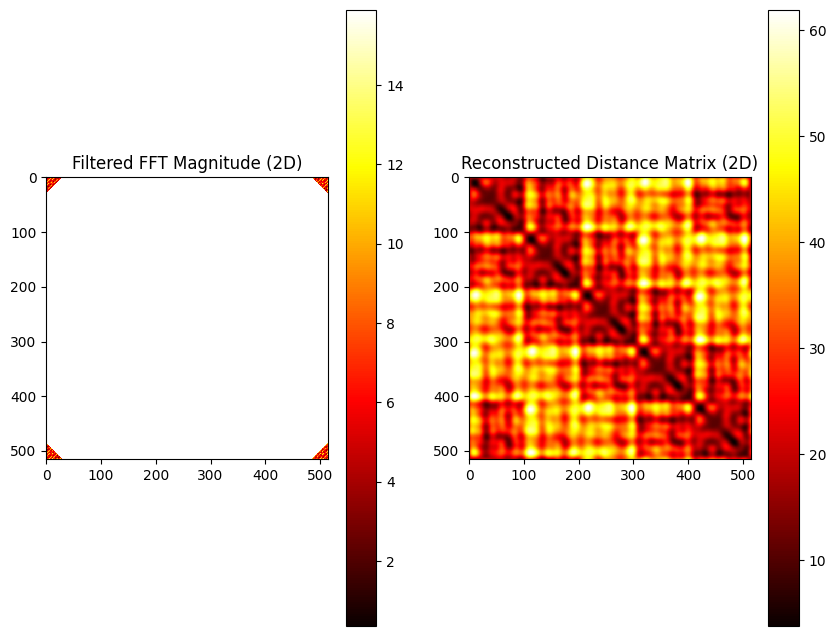

In [89]:
cutoff = 200

#low pass filter
def low_pass_filter_2d(fft_matrix, cutoff):
	#grab the center of the matrix
	center = (fft_matrix.shape[0] // 2, fft_matrix.shape[1] // 2)
	print("Center of the matrix:", center)
	# create a circle the cutoff radius
	mask = np.zeros(fft_matrix.shape, dtype=bool)
	for i in range(fft_matrix.shape[0]):
		for j in range(fft_matrix.shape[1]):
			if np.sqrt((i - center[0])**2 + (j - center[1])**2) < cutoff:
				mask[i, j] = True

	plt.figure(figsize=(10, 8))
	plt.imshow(mask, cmap='hot', interpolation='nearest')
	plt.colorbar()
	plt.show()

	plt.figure(figsize=(10, 8))
	plt.imshow(np.log(np.abs(fft_matrix)), cmap='hot', interpolation='nearest')
	plt.colorbar()
	plt.title('Log of FFT Magnitude')
	plt.show()

	# apply the mask to the FFT matrix
	filtered_fft = np.copy(fft_matrix)
	filtered_fft[mask] = 0

	# plot the filtered FFT
	plt.figure(figsize=(10, 8))
	plt.imshow(np.log(np.abs(filtered_fft)), cmap='hot', interpolation='nearest')
	plt.colorbar()
	plt.title('Filtered FFT Magnitude')
	plt.show()
	return filtered_fft

def keep_corner_triangles(matrix, size , verbose = False):
	"""
	Zero out all values in the matrix except for the lower/upper triangles
	in each of the four corners. The size of each triangle is given by `size`.
	"""
	mask = np.zeros_like(matrix, dtype=bool)
	n, m = matrix.shape

	# Top-left corner
	for i in range(size):
		for j in range(size):
			if i + j <= size - 1:
				mask[i, j] = True

	# Top-right corner
	for i in range(size):
		for j in range(m - size, m):
			if i <= (j - (m - size)):
				mask[i, j] = True

	# Bottom-left corner
	for i in range(n - size, n):
		for j in range(size):
			if (i - (n - size)) >= j:
				mask[i, j] = True

	# Bottom-right corner
	for i in range(n - size, n):
		for j in range(m - size, m):
			if (i - (n - size)) + (j - (m - size)) >= size - 1:
				mask[i, j] = True

	if verbose == True:
		#plot the mask 
		plt.figure(figsize=(10, 8))
		plt.imshow(mask, cmap='hot', interpolation='nearest')
		plt.colorbar()
		plt.title('Mask for Corner Triangles')
		plt.show()

	#print the number of elements in the mask
	if verbose == True:
		print("Number of elements in the mask:", np.sum(mask))

	result = np.zeros_like(matrix)
	result[mask] = matrix[mask]
	return result


fft_2d = np.fft.fft2(dist_matrix)
filtered_fft_2d = keep_corner_triangles(fft_2d, size =30 , verbose = True)
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(np.log(np.abs(filtered_fft_2d)), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Filtered FFT Magnitude (2D)')

#reconstruct the filtered distance matrix
reconstructed_matrix_2d = np.fft.ifft2(filtered_fft_2d)
reconstructed_matrix_2d = np.real(reconstructed_matrix_2d)
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_matrix_2d, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Reconstructed Distance Matrix (2D)')
plt.show()

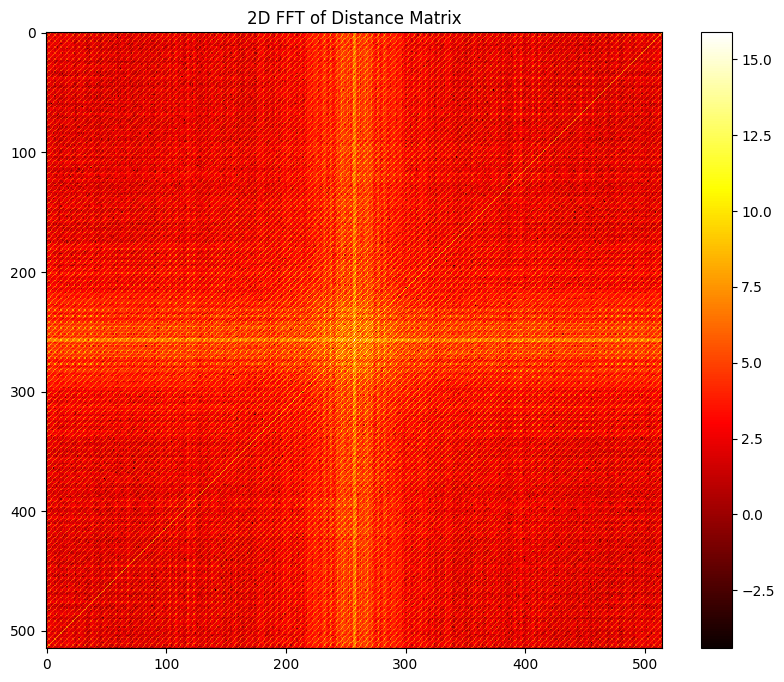

In [86]:
from scipy.fft import fft2, ifft2, fftshift
image_f = np.abs(fftshift(fft2(dist_matrix)))
plt.figure(figsize=(10, 8))
plt.imshow(np.log(image_f), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('2D FFT of Distance Matrix')
plt.show()

#filter and plot the 2D FFT


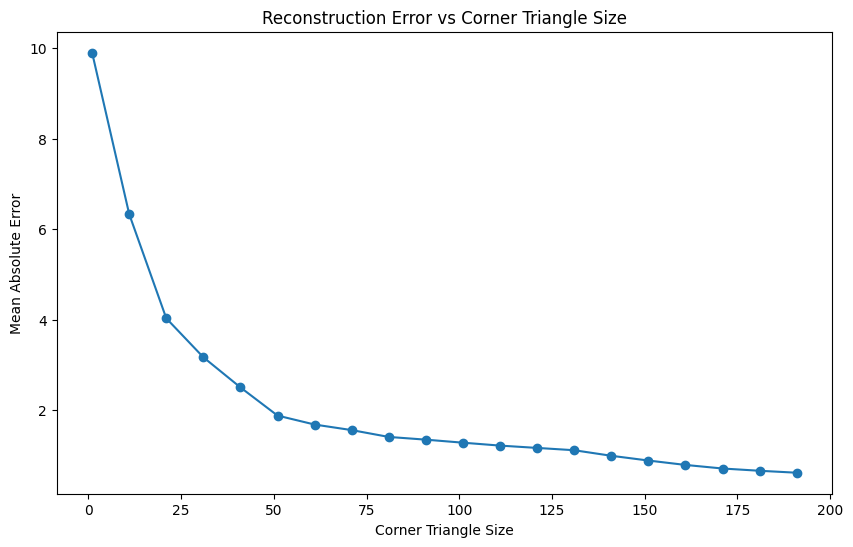

In [84]:
corner_sizes = np.arange(1, 200, 10)
corner_errors = []

for size in corner_sizes:
	filtered_fft_2d = keep_corner_triangles(fft_2d, size)
	reconstructed = np.fft.ifft2(filtered_fft_2d)
	reconstructed = np.real(reconstructed)
	err = np.mean(np.abs(dist_matrix - reconstructed))
	corner_errors.append(err)

plt.figure(figsize=(10, 6))
plt.plot(corner_sizes, corner_errors, marker='o')
plt.xlabel('Corner Triangle Size')
plt.ylabel('Mean Absolute Error')
plt.title('Reconstruction Error vs Corner Triangle Size')
plt.show()

In [ ]:
def pdb_chain_fft(pdb_path, chain_id, cutoff_1d=None, cutoff_2d=None):
	"""
	Compute 1D and 2D FFT of the distance matrix for a given PDB chain.
	Optionally apply frequency cutoffs for 1D and 2D FFTs.
	Returns:
		dict with keys:
			'fft_1d_real', 'fft_1d_imag', 'fft_2d_real', 'fft_2d_imag'
	"""
	parser = PDBParser(QUIET=True)
	structure = parser.get_structure('protein', pdb_path)
	ca_coords = []
	for model in structure:
		for chain in model:
			if chain.id == chain_id:
				for residue in chain:
					if 'CA' in residue:
						ca_coords.append(residue['CA'].get_coord())
	ca_coords = np.array(ca_coords)
	if ca_coords.shape[0] == 0:
		raise ValueError(f"No CA atoms found in chain {chain_id}")

	dist_matrix = cdist(ca_coords, ca_coords)
	n = dist_matrix.shape[0]

	# 1D FFT (row-wise)
	fft_1d = np.fft.fft(dist_matrix, axis=1)
	if cutoff_1d is not None:
		cut = min(cutoff_1d, n)
		fft_1d_filtered = np.zeros_like(fft_1d)
		fft_1d_filtered[:, :cut] = fft_1d[:, :cut]
		fft_1d = fft_1d_filtered

	# 2D FFT
	fft_2d = np.fft.fft2(dist_matrix)
	if cutoff_2d is not None:
		cut = min(cutoff_2d, n)
		fft_2d_filtered = np.zeros_like(fft_2d)
		fft_2d_filtered[:cut, :cut] = fft_2d[:cut, :cut]
		fft_2d = fft_2d_filtered

	return {
		'fft_1d_real': np.real(fft_1d),
		'fft_1d_imag': np.real(np.imag(fft_1d)),
		'fft_2d_real': np.real(fft_2d),
		'fft_2d_imag': np.real(np.imag(fft_2d))
	}

#test the function

result = pdb_chain_fft('./config/1eei.pdb', 'A', cutoff_1d=100, cutoff_2d=200)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(result['fft_1d_real'], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('1D FFT Real Part')
plt.subplot(1, 2, 2)
plt.imshow(result['fft_1d_imag'], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('1D FFT Imaginary Part')
plt.show()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(result['fft_2d_real'], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('2D FFT Real Part')
plt.subplot(1, 2, 2)
plt.imshow(result['fft_2d_imag'], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('2D FFT Imaginary Part')
plt.show()
